In [21]:
pip install soundfile

     ---------------------------------------- 1.0/1.0 MB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import pandas as pd
import soundfile as sf

# assume we have columns 'time' and 'value'
df = pd.read_csv('data.csv')

# compute sample rate, assuming times are in seconds
times = df['Time (s)'].values
n_measurements = len(times)
timespan_seconds = times[-1] - times[0]
sample_rate_hz = int(n_measurements / timespan_seconds)

# write data
data = df['A-output'].values
sf.write('A-output.wav', data, sample_rate_hz)
print("Finished writing A-output.wav file.")

data = df['B-output'].values
sf.write('B-output.wav', data, sample_rate_hz)
print("Finished writing B-output.wav file.")

Finished writing A-output.wav file.
Finished writing B-output.wav file.


In [35]:
from __future__ import division
from numpy.fft import rfft
from numpy import argmax, mean, diff, log, nonzero
from scipy.signal import blackmanharris, correlate
import sys
try:
    import soundfile as sf
except ImportError:
    from scikits.audiolab import flacread

def freq_from_fft(sig, fs):
    """
    Estimate frequency from peak of FFT
    """
    # Compute Fourier transform of windowed signal
    windowed = sig * blackmanharris(len(sig))
    f = rfft(windowed)

    # Find the peak and interpolate to get a more accurate peak
    i = argmax(abs(f))  # Just use this for less-accurate, naive version
    true_i = parabolic(log(abs(f)), i)[0]

    # Convert to equivalent frequency
    return fs * true_i / len(windowed)


def freq_from_autocorr(sig, fs):
    """
    Estimate frequency using autocorrelation
    """
    # Calculate autocorrelation and throw away the negative lags
    corr = correlate(sig, sig, mode='full')
    corr = corr[len(corr)//2:]

    # Find the first low point
    d = diff(corr)
    start = nonzero(d > 0)[0][0]

    # Find the next peak after the low point (other than 0 lag).  This bit is
    # not reliable for long signals, due to the desired peak occurring between
    # samples, and other peaks appearing higher.
    # Should use a weighting function to de-emphasize the peaks at longer lags.
    peak = argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)

    return fs / px

def parabolic(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
    f is a vector and x is an index for that vector.
    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.
    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.
    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

filenameA = "A-output.wav"
filenameB = "B-output.wav"

print('Analyzing A-output')
try:
    signal, fs = sf.read(filenameA)
except NameError:
    signal, fs, enc = flacread(filenameA)

print('Calculated frequency from FFT:', end=' ')
print('%f Hz' % freq_from_fft(signal, fs))

print('Calculated frequency from autocorrelation:', end=' ')
print('%f Hz' % freq_from_autocorr(signal, fs))
print('Maximum Acceleration:', end=' ')
print(max(abs(df['A-output'].max()), abs(df['A-output'].min())))

print('\nAnalyzing B-output')
try:
    signal, fs = sf.read(filenameB)
except NameError:
    signal, fs, enc = flacread(filenameB)

print('Calculated frequency from FFT:', end=' ')
print('%f Hz' % freq_from_fft(signal, fs))

print('Calculated frequency from autocorrelation:', end=' ')
print('%f Hz' % freq_from_autocorr(signal, fs))
print('Maximum Acceleration:', end=' ')
print(max(abs(df['B-output'].max()), abs(df['B-output'].min())))

Analyzing A-output
Calculated frequency from FFT: 21.010746 Hz
Calculated frequency from autocorrelation: 2.101787 Hz
Maximum Acceleration: 0.57968

Analyzing B-output
Calculated frequency from FFT: 2.098361 Hz
Calculated frequency from autocorrelation: 0.525113 Hz
Maximum Acceleration: 0.336365


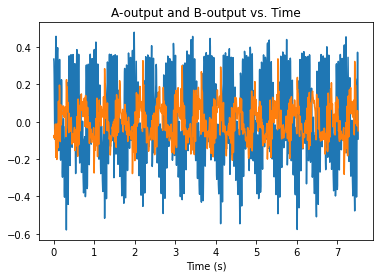

In [36]:
import matplotlib.pyplot as plt
  

plt.plot(df['Time (s)'], df['A-output'], label = 'A-output')
plt.plot(df['Time (s)'], df['B-output'], label = 'B-output')
plt.xlabel('Time (s)')
plt.title('A-output and B-output vs. Time')

plt.show()